# Inverse Noise2Noise : Apprendre la restitution d'images avec l'image propre et une image bruitée - Application avec un training discriminatif

L'idée ici est de montrer qu'avec un réseau discriminant qui va prendre en entrée notre `validation set` avec une image propre et une image bruitée, nous arrivons à un PSNR moins performant qu'avec un réseau Noise2Noise. Pour cela nous allons procéder inversement par rapport au Noise2Noise, nous allons utiliser notre `validation set` de 1000 paires d'images en tant que `train set` et notre `train set` en tant que `validation set`. Un des soucis est le nombre faible de paires d'images pour entraîner notre modèle. Nous allons pour cela faire de la data augmentation sur les 1000 images du `validation set`. 



### Connection drive

Dans un premier temps, connectez-vous au drive pour accéder au dataset :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importation des librairies pytorch

In [2]:
import torch
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Importation des données

Téléchargement de nos données provenant du dataset [Kaggle](https://www.kaggle.com/datasets/mehrdadkianiosh/noisy-images?resource=download). 

Le dataset est composé de deux fichiers : un fichier `train_data.pkl`contenant 50000 paires d'images bruitées et un fichier `val_data.pkl` contenant 1000 paires d'images bruitées.

Le dataset provient d'un challenge Kaggle, il n'y a donc pas de `test set` disponible. Nous testerons directement notre modèle sur le `validation set`.


Pour entraîner notre modèle discrimant, nous allons utiliser le `validation set`.

In [4]:
# import data
noisy_imgs_1 , noisy_imgs_2 = torch.load('/content/drive/MyDrive/DeepL_Project/dataset/train_data.pkl')
noisy_imgs , clean_imgs = torch.load('/content/drive/MyDrive/DeepL_Project/dataset/val_data.pkl')

print(noisy_imgs_1.shape)
print(noisy_imgs.shape)

# normalized data between 0 and 1 (because some torch function are optimized for inputs between 0 & 1)
noisy_imgs_1 = noisy_imgs_1/255
noisy_imgs_2 = noisy_imgs_2/255
noisy_imgs = noisy_imgs/255
clean_imgs = clean_imgs/255

torch.Size([50000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


**Visualisation de notre dataset**

Importez la librairie matplotlib pour visualiser nos données :

In [5]:
from matplotlib import pyplot as plt

Utilisation de `torch.permute` pour avoir une vue du tenseur d'origine :



Text(0.5, 1.0, 'Example of a clean_imgs from the validation set')

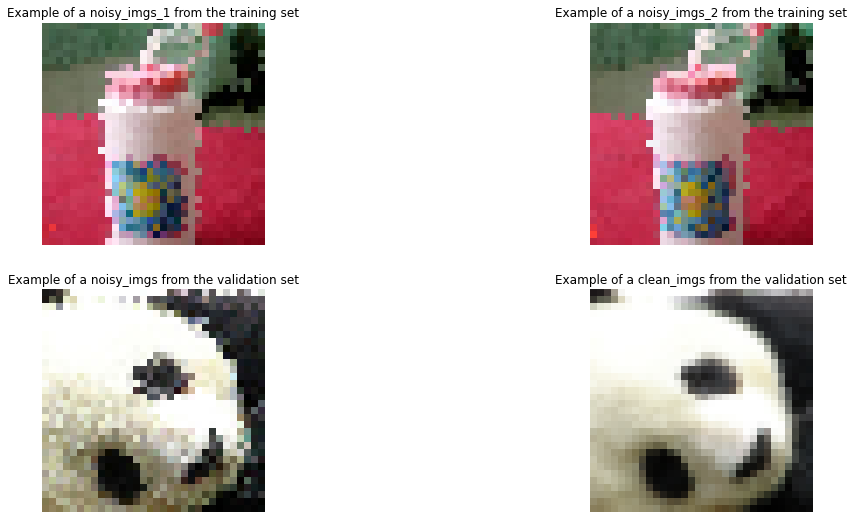

In [6]:
# create figure
fig = plt.figure(figsize=(18, 9))
    
# setting values to rows and column variables
rows = 2
columns = 2

# adds a subplot
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(noisy_imgs_1[7].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs_1 from the training set")

# adds a subplot
fig.add_subplot(rows, columns, 2)
    
# showing image
plt.imshow(noisy_imgs_2[7].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs_2 from the training set")
      
# adds a subplot 
fig.add_subplot(rows, columns, 3)
      
# showing image
plt.imshow(noisy_imgs[13].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs from the validation set")

# adds a subplot 
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(clean_imgs[13].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a clean_imgs from the validation set")

### Calcul du PSNR avant entraînement de notre modèle

Pour évaluer nos modèles, nous utiliserons la mesure du **PSNR**, exprimée en décibel (dB).

Le PSNR permet de quantifier la performance des modèles en mesurant la qualité de reconstruction de l'image compressée par rapport à l'image originale.

Pour pouvoir étudier si notre modèle est performant, nous pouvons comparer le PSNR du `train set`, utilisé comme `validation set` ici qui calcule le PSNR entre nos deux images `image bruitées`, avec le PSNR après entraînement du modèle qui calculera le PSNR entre notre `predicted image` et une `image bruitée`.

En conséquence, si nous obtenons un PSNR plus élevé après notre modèle, cela signifie que notre signal et donc le traitement de restauration ou d'amélioration sont meilleurs. 

In [7]:
def psnr(denoised , ground_truth):
# Peak Signal to Noise Ratio : denoised and ground_truth have values between 0 and 1
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

sum = 0
nb_img = noisy_imgs_1.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(noisy_imgs_1[i].cpu(), noisy_imgs_2[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean : " + str(mean_psnr) + " dB")

PSNR mean : 17.747283432474138 dB


Nous obtenons un PSNR moyen de 17.75 dB pour notre validation set qui est le `train set`. Celui-ci est beaucoup plus bas que dans les deux autres réseaux du début car nous avons deux images bruitées. Implémentons notre modèle et comparons notre PNSR final à celui-ci.

## Architecture U-Net

Nous implémentons une structure similaire au U-Network que nous avons implémenté auparavant :

In [8]:
# network architecture
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        pass
        
        self.conv3_32 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn32 = nn.BatchNorm2d(32)
        self.conv32_64 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn64_1 = nn.BatchNorm2d(64)
        self.pool2_2_1 = nn.AvgPool2d(kernel_size=(2,2))
        self.conv64_64 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn64_2 = nn.BatchNorm2d(64)
        self.pool2_2_2 = nn.AvgPool2d(kernel_size=(2,2))
        self.upsample2_1 = nn.Upsample(scale_factor=2)
        self.t_conv64_64 = nn.ConvTranspose2d(64, 64, kernel_size=3)
        self.upsample2_2 = nn.Upsample(scale_factor=2)
        self.t_conv128_64 = nn.ConvTranspose2d(128, 64, kernel_size=3)
        self.t_conv64_32 = nn.ConvTranspose2d(64, 32, kernel_size=3)
        self.conv35_32 = nn.Conv2d(35, 32, kernel_size=3)
        self.t_conv32_3 = nn.ConvTranspose2d(32, 3, kernel_size=3)
        
    
    def forward(self, x):
        x0 = x
        x = F.relu(self.conv3_32(x))
        x = F.relu(self.conv32_64(x))
        x1 = F.relu(self.pool2_2_1(x))
        x = F.relu(self.conv64_64(x1))
        x = F.relu(self.pool2_2_2(x))
        x = F.relu(self.upsample2_1(x))
        x = F.relu(self.t_conv64_64(x))
        x = torch.cat((x, x1), dim=1)
        x = F.relu(self.upsample2_2(x))
        x = F.relu(self.t_conv128_64(x))
        x = F.relu(self.t_conv64_32(x))
        x = torch.cat((x, x0), dim=1)
        x = F.relu(self.conv35_32(x))
        x = F.relu(self.t_conv32_3(x))

        return x

In [9]:
class Model(nn.Module):
    def __init__(self) -> None:
        # instantiation of the model, loss function and optimizer
        super().__init__()
        self.autoencoder = Network().to(device)
        self.criterion = nn.MSELoss().to(device)
        self.optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr = 1e-3)
        self.weight_initialization()
        pass

    def weight_initialization(self):
        for mod in self.modules():
          if isinstance(mod, nn.Conv2d):
            nn.init.kaiming_normal_(mod.weight.data)
            mod.bias.data.zero_()

    def load_last_trained_model (self) :
    # to load the parameters saved in parameters_models_Discriminative.pth into the model
    # self.load_state_dict(torch.load(path, map_location=torch.device(device)))        
        saved_model_path = "/content/drive/MyDrive/DeepL_Project/parameters_models_Discriminative.pth"
        model = torch.load(saved_model_path)
        self.load_state_dict(model)
        self.to(device)
        pass
  
    def save_parameters_Model(self) :
        # to save our parameters in parameters_models.pth
        torch.save(self.state_dict(), '/content/drive/MyDrive/DeepL_Project/parameters_models_Discriminative.pth')
        pass 

    def train(self, train_imgs_1, train_imgs_2, nb_epochs) -> None:
        # train_imgs_1 : tensor of size (N, C, H, W) with a noisy version of the images     
        # train_imgs_2 : tensor of size (N, C, H, W) with another noisy version of the same images, which only differs from the input by their noise
        mini_batch_size = 100
        loss_list = []

        for e in range(nb_epochs):
            acc_loss = 0
            for b in range(0, train_imgs_1.size(0), mini_batch_size):
                output = self.autoencoder(train_imgs_1.narrow(0, b, mini_batch_size).to(device))
                loss = self.criterion(output, train_imgs_2.narrow(0, b, mini_batch_size).to(device))
                acc_loss = acc_loss + loss.item()
                # self.autoencoder.zero_grad()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(e, acc_loss)

            print("Loss : ", loss.item())
            loss_list.append(loss.item())
        return loss_list
        pass

    def prediction(self, val_input) -> torch.Tensor:
        # val_input : tensor of size (N1, C, H, W) that has to be denoised by the trained network
        # returns a tensor of the size (N1, C, H, W)
        return self.autoencoder(val_input)
        pass

torch.cuda.empty_cache()

**Entraînement de notre modèle**

Installez la librairie `ipython-autotime` afin de pouvoir indiquer le temps d'exécution de notre modèle :

In [10]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
time: 646 µs (started: 2023-03-01 22:06:15 +00:00)


In [11]:
m = Model()

time: 18.4 ms (started: 2023-03-01 22:06:15 +00:00)


Téléchargez le dernier train modèle sauvegardé afin de ne pas réexécuter le modèle par la suite : 

In [14]:
m.load_last_trained_model()

time: 9.22 ms (started: 2023-03-01 22:07:41 +00:00)




---



*Les deux cellules suivantes sont à exécuter uniquement si vous voulez entraîner d'autres architectures de réseaux.*

Exécuter la cellule uniquement si vous voulez entraîné un nouveau réseau :

Ici nous mettons les images du `validation set` en entrée :

In [12]:
loss_list = m.train(noisy_imgs.float(), clean_imgs.float(), nb_epochs = 20)

0 1.6949013322591782
Loss :  0.12777596712112427
1 1.0029632300138474
Loss :  0.08887219429016113
2 0.6310812160372734
Loss :  0.0463971346616745
3 0.34093672037124634
Loss :  0.028416849672794342
4 0.22558650188148022
Loss :  0.019547738134860992
5 0.16908553708344698
Loss :  0.016156721860170364
6 0.1445505367591977
Loss :  0.014164317399263382
7 0.12940671294927597
Loss :  0.012910932302474976
8 0.11880552303045988
Loss :  0.011963987722992897
9 0.11146799847483635
Loss :  0.011465280316770077
10 0.1052881283685565
Loss :  0.010725565254688263
11 0.1000000350177288
Loss :  0.010258262977004051
12 0.098068174906075
Loss :  0.010158216580748558
13 0.0943167693912983
Loss :  0.009700802154839039
14 0.09090311173349619
Loss :  0.00938127376139164
15 0.07701108744367957
Loss :  0.007647065911442041
16 0.06921105505898595
Loss :  0.007194869685918093
17 0.0661758491769433
Loss :  0.006957209203392267
18 0.06403302680701017
Loss :  0.00676735257729888
19 0.06243957066908479
Loss :  0.00656

Le fichier `parameters_models_Discriminative.pth` permet de sauvegarder les paramètres du training pour garder en mémoire les performances des différentes architectures réseaux (pas besoin de relancer de training pour une architecture qui a déjà été lancée ! ). Dans le fichier  `parameters_models_Discriminative.pth` se trouve uniquement les paramètres de notre modèle sélectionné. Si vous voulez entraîner d'autres réseaux et les sauvegarder dans le fichier, exécutez la cellule suivante :


In [13]:
m.save_parameters_Model()

time: 13.3 ms (started: 2023-03-01 22:07:41 +00:00)


**Visualition de la `loss function` en fonction du nombre d'epochs**

Importez la libraire numpy :

In [15]:
import numpy as np

time: 693 µs (started: 2023-03-01 22:07:44 +00:00)


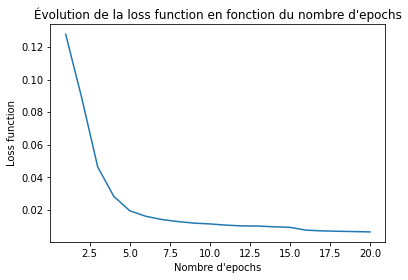

time: 231 ms (started: 2023-03-01 22:07:45 +00:00)


In [16]:
# create a numpy array manually to have our number of epochs
epochs = np.arange(1,21)

# create figure
plt.plot(epochs,loss_list)

# add titles
plt.title("Évolution de la loss function en fonction du nombre d'epochs")
plt.xlabel("Nombre d'epochs")
plt.ylabel('Loss function')

# showing figure
plt.show()

Nous observons que notre `loss function` décroît bien en fonction du nombre d'epochs.

**Déclaration et visualation de notre `predicted image`** 

In [ ]:
predicted_img = m.prediction(noisy_imgs_1.float().to(device))

with torch.no_grad():
  plt.imshow(predicted_img[7].cpu().permute(1,2,0))

### Visualisation finale des données du `validation set` qui est ici notre `train set`

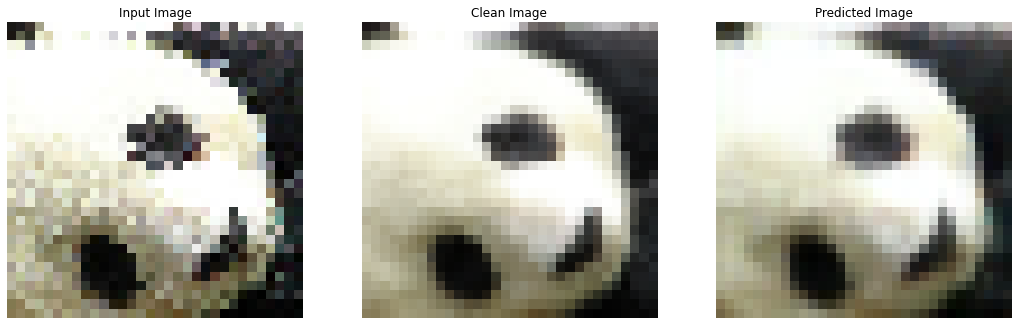

time: 187 ms (started: 2023-02-28 18:09:52 +00:00)


In [ ]:
with torch.no_grad():

  # create figure
  fig = plt.figure(figsize=(18, 9))
    
  # setting values to rows and column variables
  rows = 1
  columns = 3

  # adds a subplot 
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(noisy_imgs_1[7].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Input Image 1")

  # adds a subplot 
  fig.add_subplot(rows, columns, 2)
    
  # showing image
  plt.imshow(noisy_imgs_2[7].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Input Image 2")
      
  # adds a subplot 
  fig.add_subplot(rows, columns, 3)
      
  # showing image
  plt.imshow(predicted_img[7].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Predicted Image")

Nous remarquons que notre `predicted image` est très proche visuellement de la `clean image`.

Il est important de souligner que notre jeu de données est en base résolution pour permettre de réduire les temps de calculs pouvant être trop volumineux en haute réoslution. Notre `clean image` et `predicted image` restent donc floues à l'oeil nu.

### Calcul du PSNR après entraînement de notre modèle

In [ ]:
def psnr(denoised , ground_truth):
# Peak Signal to Noise Ratio: denoised and grounḋ_truth have values between 0 and 1
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

sum = 0
nb_img = predicted_img.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(predicted_img[i].cpu(), noisy_imgs_1[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean : " + str(mean_psnr) + " dB")

PSNR mean : 25.358441556930543 dB
time: 108 ms (started: 2023-02-28 18:09:40 +00:00)


Nous obtenons un PSNR moyen de X dB après l'entraînement de notre U-Net discriminant.

En conséquence, nous obtenons un PSNR plus élevé après entraînement de notre modèle, cela signifie que notre signal et donc le traitement de restauration ou d'amélioration sont meilleurs. Néanmoins, nous remarquons que la méthode Noise2Noise est largement préférable pour apprendre la restitution d'images propres.